In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from skspatial.objects import LineSegment, Line, Vector

# some helper functions
from helpers import (
    get_arc_point,
    draw_arc,
    rotate,
    translate,
    flip_y,
    flip_x,
    optimize_points,
    chaikin,
    rotate_point,
    scale,
)
from pcb_json import (
    dump_json,
    plot_json,
    create_via,
    create_pad,
    create_pin,
    create_silk,
    create_mounting_hole,
)

from enum import Enum

Layer = Enum("Layer", "FRONT BACK")

In [2]:
# Track width and spacing (mm)
TRACK_WIDTH = 0.3
TRACK_SPACING = 0.18

INNER_DIAMETER = 4

OUNCES = 2
COPPER_THICKNESS = OUNCES * 0.0348 # oz/sqr_foot * mm/(oz/sqr_foot) >>>> convert to mm

VOLTAGE = 3.7

# via defaults (mm)
VIA_DIAM = 0.8
VIA_DRILL = 0.4

# this is for the PCB connector - see https://www.farnell.com/datasheets/2003059.pdf
PAD_ENABLE = False
PAD_WIDTH = 3
PAD_HEIGHT = 2
PAD_PITCH = 2.5

# Vias for connecting to the coils
COIL_INPUT_VIAS_ENABLE = True

# PCB edge cuts
PCB_EDGE_CUTS = True

# Coil net name
COIL_NET_NAME = "coils"

# this is for a 1.27mm pitch pin
PIN_DIAM = 1.0
PIN_DRILL = 0.65

In [3]:
# Coil params

MAX_DIAMETER = 28 # mm
max_radius = ((MAX_DIAMETER - INNER_DIAMETER) / 2) - TRACK_SPACING

TURNS = (max_radius) / (TRACK_WIDTH + TRACK_SPACING)
TURNS = int(TURNS)


COIL_CENTER_RADIUS = 16
COIL_VIA_RADIUS = 17

# Coil input vias
COIL_INPUT_VIA_RADIUS = 22

# Arbitrary Coil Generation

In [4]:
# templates must be simetric around the X axis and must include the center points on both size (e.g. (X1, 0).... (X2, 0) )
# template must also be convex
triangle = [
    (-3.5, 0),
    (-3.5, -0.01),
    (1.9, -1.45),
    (1.9, 0.0),
    (1.9, 1.45),
    (-3.5, 0.01),
]

hexagon = [
    (-1, 0),
    (-0.5, -0.86603),
    (0.5, -0.86603),
    (1, 0),
    (0.5, 0.86603),
    (-0.5, 0.86603),
]

hexagon_cw = [
    (-1, 0),
    (-0.5, 0.86603),
    (0.5, 0.86603),
    (1, 0),
    (0.5, -0.86603),
    (-0.5, -0.86603),
]

vert_hexagon = [
    (-0.86603, 0),
    (-0.86603, -0.5),
    (0, -1),
    (0.86603, -0.5),
    (0.86603, 0),
    (0.86603, 0.5),
    (0, 1),
    (-0.86603, 0.5),
]


template = np.multiply(hexagon, INNER_DIAMETER / 2)

(-4.2, 0.2, -1.905266, 1.905266)

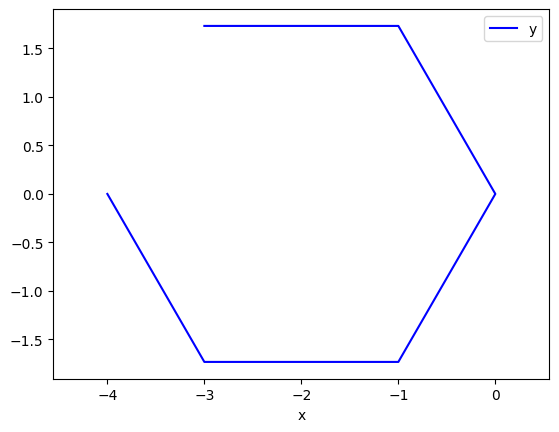

In [5]:
# plot the template shape wrapping around to the first point
df = pd.DataFrame(template + [template[0]], columns=["x", "y"])
ax = df.plot.line(x="x", y="y", color="blue")
ax.axis("equal")

In [6]:
def calculate_point(point, point1, point2, spacing, turn):
    reference_vector = Vector([-100, 0])
    angle = np.rad2deg(Vector(point).angle_between(reference_vector))
    if point[1] > 0:
        angle = 360 - angle
    vector = Vector(point1) - Vector(point2)
    normal = vector / np.linalg.norm(vector)
    # rotate the vector 90 degrees
    normal = np.array([-normal[1], normal[0]])
    # move the  point along the normal vector by the spacing
    offset = spacing * (turn * 360 + angle) / 360
    coil_point = point + normal * offset
    return (coil_point[0], coil_point[1])


def get_points(template, turns, spacing):
    coil_points = [(0,0)]
    reference_vector = Vector([-100, 0])
    template_index = 0
    template_length = len(template)
    for turn in range(turns * template_length):
        point1 = template[template_index % template_length]
        point2 = template[(template_index + 1) % template_length]

        # calculate the new positions of the points
        coil_point1 = calculate_point(
            point1, point1, point2, spacing, template_index // template_length
        )
        coil_point2 = calculate_point(
            point2, point1, point2, spacing, (template_index + 1) // template_length
        )
        # adjust the previous point so that the previous line intersects with this new line
        # this prevents any cutting of corners
        if len(coil_points) >= 2:
            # create a line from the previous two points
            line1 = Line(
                coil_points[len(coil_points) - 2],
                np.array(coil_points[len(coil_points) - 1])
                - np.array(coil_points[len(coil_points) - 2]),
            )
            # create a line from the two new points
            line2 = Line(
                np.array(coil_point1),
                np.array(np.array(coil_point1) - np.array(coil_point2)),
            )
            # find the intersection of the two lines
            try:
                intersection = line1.intersect_line(line2)
                # replace the previous point with the intersection
                coil_points[len(coil_points) - 1] = intersection
                # add the new point
                coil_points.append(coil_point2)
            except:
                # the lines did not intersect so just add the points
                coil_points.append(coil_point1)
                coil_points.append(coil_point2)
        else:
            coil_points.append(coil_point1)
            coil_points.append(coil_point2)

        template_index = template_index + 1
    return coil_points

In [7]:
def get_spiral(turns, start_radius, thickness, layer=Layer.FRONT):
    points = [(0,0)]
    # create a starting point in the center
    for angle in np.arange(0, turns * 360, 1):
        radius = start_radius + thickness * angle / 360
        if layer == Layer.BACK:
            x = radius * np.cos(np.deg2rad(angle + 180))
            y = radius * np.sin(np.deg2rad(angle + 180))
            points.append((x, -y))
        else:
            x = radius * np.cos(np.deg2rad(angle))
            y = radius * np.sin(np.deg2rad(angle))
            points.append((x, y))
    return points

In [8]:
points = chaikin(
    optimize_points(get_points(template, TURNS, TRACK_SPACING + TRACK_WIDTH)), 2
)

# move the connection point (where the via will go) away from the middle)
del points[0] # delete line to the middle
del points[0] # simplify the geometry at the beginning
del points[0]
del points[0]
del points[1]
del points[1]
del points[1]
del points[-1]
del points[-1]
del points[-1]


Optimised from 146 to 146 points


In [9]:
# Move the center via away from the left side
points[0] = [points[0][0] + VIA_DIAM / 2 + TRACK_SPACING, 0]
points[1] = [points[1][0] + VIA_DIAM / 2 + TRACK_SPACING, points[1][1]]


In [10]:
print("Track points", len(points), len(points))
print("first point:", points[0], "  last point:", points[-1])
print("Able to fit", TURNS, "turns")

numpy_points = np.array(points)
min_x = min(numpy_points[:, 0])
max_x = max(numpy_points[:, 0])
min_y = min(numpy_points[:, 1])
max_y = max(numpy_points[:, 1])

print("total height:", max_y - min_y, "\ntotal width:", max_x - min_x)

# extend the last line
x_diff = points[-1][0] - points[-2][0]
y_diff = points[-1][1] - points[-2][1]
points.append((points[-1][0] + x_diff, points[-1][1] + y_diff))

if min_x - TRACK_SPACING - VIA_DIAM / 2 <= points[-1][0]:
    points.append((points[-1][0], 0)) # make sure the via will end up on the x-axis
    print("Via should have enough room on the side already")
else:
    points.append((min_x - TRACK_SPACING - VIA_DIAM, 0)) # add a little more track going away from the coil for a via
    print("Added a little more track to keep the via away from the coil")

Track points 571 571
first point: [-1.3296843881866265, 0]   last point: [-11.516907578453598, 6.487447277762641]
Able to fit 24 turns
total height: 26.485579300672313 
total width: 29.033002515346944
Added a little more track to keep the via away from the coil


In [11]:
points_f = points.copy()
# Don't go all the way to the outside via on the first layer
del points_f[-1]
del points_f[-1]
points_f[-1] = [points_f[-1][0] + (x_diff * 2 / 3), points_f[-1][1] + (y_diff * 2 / 3)]
points_f.append((points[-1][0], points_f[-1][1])) # little entry trace coming in from the left side

# first internal layer is just the mirror of the front, but all the way to the outside via
points_m1 = flip_y(points)

# Move the internal via to the other side for the second internal layer
points_m2 = points.copy()
del points_m2[0]
del points_m2[0]
del points_m2[0]
del points_m2[0]
del points_m2[0]
del points_m2[0]
del points_m2[0]
del points_m2[0]
del points_m2[1]
del points_m2[1]
del points_m2[2]
del points_m2[2]
points_m2[0] = [points_m2[0][0] - VIA_DIAM - TRACK_SPACING, 0]
points_m2[1] = [points_m2[1][0] - VIA_DIAM - TRACK_SPACING, points_m2[1][1]]

points_b = flip_y(points_m2)
# Don't go all the way to the via on the bottom layer
del points_b[-1]
del points_b[-1]
points_b[-1] = [points_b[-1][0] + (x_diff * 2 / 3), points_b[-1][1] - (y_diff * 2 / 3)]
points_b.append((points[-1][0], points_b[-1][1])) # little exit trace coming off the left side


(-16.941021663178027,
 16.156011494035287,
 -14.706614444759547,
 14.706614444759547)

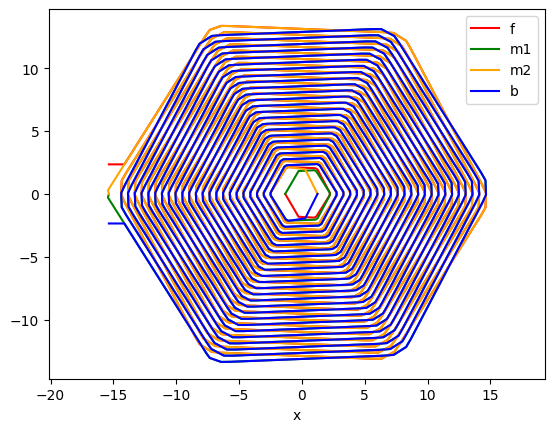

In [12]:
ax = None

df = pd.DataFrame(points_f, columns=["x", "f"])
ax = df.plot.line(x="x", y="f", color="red", ax=ax)

df = pd.DataFrame(points_m1, columns=["x", "m1"])
ax = df.plot.line(x="x", y="m1", color="green", ax=ax)

df = pd.DataFrame(points_m2, columns=["x", "m2"])
ax = df.plot.line(x="x", y="m2", color="orange", ax=ax)

df = pd.DataFrame(points_b, columns=["x", "b"])
ax = df.plot.line(x="x", y="b", color="blue", ax=ax)

ax.axis("equal")

# Generate PCB Layout

In [13]:
# calculate the total length of the track to compute the resistance
length_front = 0
for i in range(len(points_f) - 1):
    length_front += np.linalg.norm(
        np.array(points_f[i + 1]) - np.array(points_f[i])
    )
print("Total length front", length_front)

length_back = 0
for i in range(len(points_b) - 1):
    length_back += np.linalg.norm(
        np.array(points_b[i + 1]) - np.array(points_b[i])
    )
print("Total length back", length_back)

length_mid1 = 0
for i in range(len(points_m1) -1):
    length_mid1 += np.linalg.norm(
        np.array(points_m1[i + 1]) - np.array(points_m1[i])
    )

length_mid2 = 0
for i in range(len(points_m2) -1):
    length_mid2 += np.linalg.norm(
        np.array(points_m2[i + 1]) - np.array(points_m2[i])
    )

estimated_resistance = (length_front + length_mid1 + length_mid2 + length_back) / (TRACK_WIDTH * COPPER_THICKNESS)
estimated_resistance *= 17.4e-6 ## copper resistivity (near ambient temperature)
print("Estimated resistance:", estimated_resistance, "ohms")

Total length front 1225.3261797684959
Total length back 1218.6700325160523
Estimated resistance: 4.075842016012188 ohms


In [14]:
vias = []
tracks_f = []
tracks_in = []
tracks_b = []
pads = []
pins = []
mounting_holes = []
silk = []
components = []
edge_cuts = []

tracks_m1 = []
tracks_m2 = []

## KiCAD's y value increases as you go LOWER on the screen, so that's why I flip all the y values
tracks_f.append({"net": COIL_NET_NAME, "pts": flip_y(points_f)})
tracks_m1.append({"net": COIL_NET_NAME, "pts": flip_y(points_m1)})
tracks_in.append(tracks_m1.copy())
tracks_m2.append({"net": COIL_NET_NAME, "pts": flip_y(points_m2)})
tracks_in.append(tracks_m2.copy())
tracks_b.append({"net": COIL_NET_NAME, "pts": flip_y(points_b)})

vias.append(create_via(points_f[0], COIL_NET_NAME)) ## put a via at the first point of the front coil (connect f to m1)
vias.append(create_via(points_m1[-1], COIL_NET_NAME)) ## put a via at the last point of the mid1 coil (connect m1 to m2)
vias.append(create_via(points_b[0], COIL_NET_NAME)) ## put a via at the first point of the back coil (connect b to m2)

# Generate JSON

In [15]:
filename = "4Layer_Hex_coil_" + str(TRACK_WIDTH) + "mm_trace_" + str(TURNS) + "_turns_" + '{0:.2f}'.format(VOLTAGE / estimated_resistance * TURNS) + "_score_.json"

# dump out the json version
json_result = dump_json(
    filename=filename,
    track_width=TRACK_WIDTH,
    pin_diam=PIN_DIAM,
    pin_drill=PIN_DRILL,
    via_diam=VIA_DIAM,
    via_drill=VIA_DRILL,
    vias=vias,
    pins=pins,
    pads=pads,
    silk=silk,
    tracks_f=tracks_f,
    tracks_in=tracks_in,
    tracks_b=tracks_b,
    mounting_holes=mounting_holes,
    edge_cuts=edge_cuts,
    components=components,
)

#print(json_result)

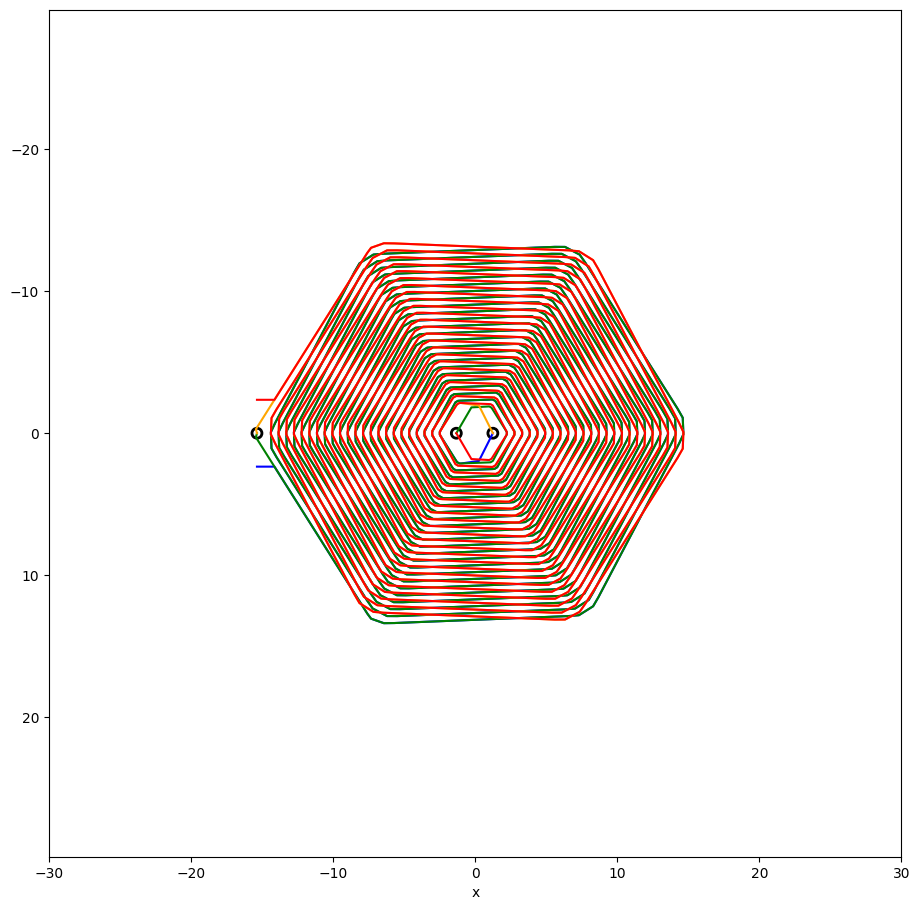

In [16]:
# plot the json
plot_json(json_result)

In [17]:
print("\n:::: Final Results: ::::\n")
print("Track Width:", TRACK_WIDTH)
print("Track Spacing:", TRACK_SPACING)
print("Turns:", TURNS)
print("Coil Dimensions:", max_y - min_y, "mm  x ", max_x - min_x, "mm")
print("Estimated Resistance:", estimated_resistance, "ohms")

print("\nWith", VOLTAGE, "Volts, the maximum current will be:", VOLTAGE / estimated_resistance, "Amps")

print("The magnetic coefficient estimate (I * TURNS * layers) is:", '{0:.2f}'.format(VOLTAGE / estimated_resistance * TURNS * 4))


:::: Final Results: ::::

Track Width: 0.3
Track Spacing: 0.18
Turns: 24
Coil Dimensions: 26.485579300672313 mm  x  29.033002515346944 mm
Estimated Resistance: 4.075842016012188 ohms

With 3.7 Volts, the maximum current will be: 0.9077878841879371 Amps
The magnetic coefficient estimate (I * TURNS * layers) is: 87.15
